<h1 style = 'text-align: center'> <b>DỰ ĐOÁN BIẾN ĐỘNG GIÁ CỔ PHIẾU</b></h1>

<b>Ứng viên: Võ Nguyễn Hoàng Kim</b>

<h2><b>A. PHÂN TÍCH</b></h2>

<h3><b>a. Yêu cầu</b></h3>

- <b>Yêu cầu: </b>Hãy sử dụng dữ liệu được cung cấp (dữ liệu giá và khối lượng của một vài mã cổ phiếu) để xây dựng một số mô hình dự đoán biến động giá cổ phiếu, với công thức:

<h5 style = 'text-align: center'> Biến động giá cổ phiếu = Giá cổ phiếu N (phút hoặc giờ hoặc ngày) sau - Giá cổ phiếu hiện tại.</h5>

<h3><b>b. Nhận xét</b></h3>

- <b>Dữ liệu:</b> Mặc dù dữ liệu được cung cấp là giá cổ phiếu được ghi nhận theo từng phút, nhưng có một số ngày dữ liệu được ghi nhận vào thời gian không đều nhau, do đó, dữ liệu sẽ được chuyển đổi thành giá cổ phiếu được thống kê theo ngày
    - Bên cạnh đó, do không có kiến thức sâu về các loại giá và tâm quan trọng của chúng, nên giá mà em sử dụng (được tham khảo thông tin ở các trang Web) ở đây là Close để phục vụ cho việc thực hiện huấn luyện và kiểm thử mô hình.
<br>
<br>

- <b>Bài toán đặt ra:</b> Đối với yêu cầu đặt ra, em nghĩ rằng vấn đề cần giải quyết chính là tìm kiếm một mô hình có khả năng dự đoán giá cổ phiểu trong một khoảng thời gian N. Từ giá trị dự đoán này sẽ tính được biến động của giá cổ phiếu.
<br>
<br>

- <b>Mô hình: </b>Việc dự đoán giá cổ phiếu có thể sử dụng nhiều loại mô hình khác nhau như <b>Regression</b>, <b>Random Forest</b>, <b>Long Short-Term Memory</b>,...
    - Em đã thử nghiệm với 2 loại mô hình là <b>Multivariable Linear Regression</b> và <b>Long Short-Term Memory</b>, và nhận thấy rằng MLR tuy cài đặt đơn giản và thời gian thực thi nhanh chóng, tuy nhiên, nó cần dữ liệu của các thông số khác nhau (như Open, High, Volume, Low) để có thể đưa ra giá trị cho Close tương ứng. Với cách này, không đáp ứng được việc dự đoán kết quả trong khoảng thời gian N ngày.
    - Còn đối với LSTM, đây là mô hình phù hợp để xử lý các loại dữ liệu Time-series như dữ liệu cổ phiếu được cung cấp. Do đó, em đã thử cài đặt và nhận được kết quả khá tốt (được thể hiện ở mục cài đặt bên dưới)

<h2><b>B. CÀI ĐẶT</b></h2>

<h3><b>1. Cài đặt các thư viện cần thiết</b></h3>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

<h3><b>2. Xử lý dữ liệu</b></h3>

<h4><b>a. Đọc dữ liệu</b></h4>

In [19]:
# read dataset

# FPT = pd.read_csv('FPT.csv', parse_dates=['Date/Time'])
PNJ = pd.read_csv('PNJ.csv', parse_dates=['Date/Time'])
# VIC = pd.read_csv('VIC.csv', parse_dates=['Date/Time'])
# MSN = pd.read_csv('MSN.csv', parse_dates=['Date/Time'])
data = PNJ

<h4><b>b. Xử lý dữ liệu</b></h4>

- Do dữ liệu được cung cấp ghi nhận giá cổ phiếu theo từng phút, nên vì thế, ở bước này cần cập nhật lại dữ liệu với các giá trị sẽ được tính trên một ngày.
- Việc nhóm dữ liệu được thực hiện như sau:
    - Đối với <b>Open</b>: Sẽ là giá được ghi nhận đầu tiên trong ngày
    - Đối với <b>High</b>: Sẽ là giá cao nhất được ghi nhận trong ngày
    - Đối với <b>Low</b>: Sẽ là giá thấp nhất được ghi nhận trong ngày
    - Đối với <b>Close</b>: Sẽ là giá được ghi nhận cuối cùng trong ngày
    - Đối với <b>Volume</b>: Sẽ là tổng của tất cả khối lượng giao dịch trong ngày
- Do chỉ sử dụng <b>Close</b> nên tiến hành lấy dữ liệu trên cột đó (bỏ qua những dữ liệu không cần thiết khác) 
- Dữ liệu được biểu diễn bằng biểu đồ đường thẳng   

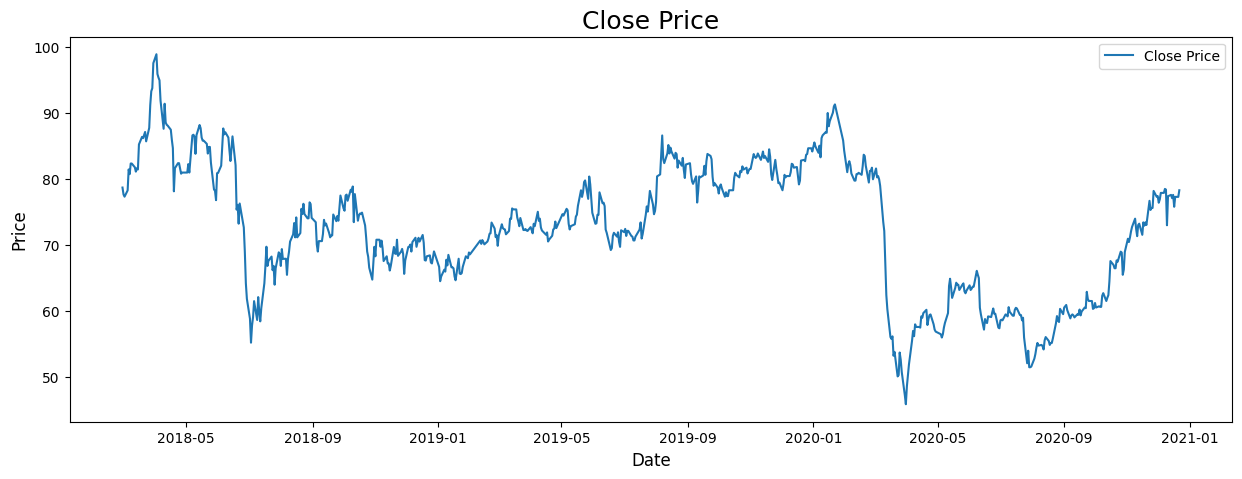

In [20]:
# convert "Date/Time" column to date type
data['Date'] = data['Date/Time'].dt.date

# Group data by date column
grouped_data = data.groupby(['Date']).agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
})

# get the Close Price values 
data = grouped_data.filter(['Close'])
prices = data.values

# plot Close Price value
plt.figure(figsize=(15,5))
plt.title('Close Price', fontsize =18)
plt.plot(data)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Close Price'])
plt.show()


- Thiết lập kích thước cho tập test bằng biến dữ liệu <b>*train_size*</b>. Nó sẽ bằng 80% kích thước của tập dữ liệu ban đầu
- Chuẩn hoá dữ liệu giúp mô hình có thể học dễ dàng và đạt hiệu quả tốt hơn, ở đây sử dụng bộ MinMaxScaler để chuẩn hoá các giá trị về trong khoảng [0,1]
- Xác định bước thời gian <b>*time_step*</b> mà mô hình sử dụng trong việc dự đoán giá cổ phiếu trong tương lai, nghĩa là mô hình sẽ sử dụng dữ liệu của <b>*time_step*</b> ngày trước đó để đưa ra dự đoán giá cổ phiếu cho ngày tiếp theo

In [21]:
# set up the training size 
train_size = int(np.ceil(len(prices) * .8))

# normalize data by MinMaxScaler in range [0,1]
scaler = MinMaxScaler(feature_range=(0, 1))
prices_scaled = scaler.fit_transform(prices)

# number of time steps to predict future stock prices
time_step = 100 

<h4><b>c. Thiết lập tập huấn luyện</b></h4>

- Tập huấn luyện được lấy từ tập dữ liệu ban đầu, tức là lấy <b>*train_size*</b> hàng của tập dữ liệu ban đầu
- Tập huấn luyện này được chia thành hai tập nhỏ là <b>*X_train*</b> và <b>*y_train*</b> 

In [5]:
train_data = prices_scaled[:train_size, :]

X_train = []
y_train = []

# get data for X_train and y_train
for i in range(time_step, len(train_data)):
    X_train.append(train_data[i-time_step:i, 0])
    y_train.append(train_data[i, 0])

# convert the X_train and y_train to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)

# reshape the data
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

<h4><b>d. Xây dựng mô hình LSTM</b></h4>

- Mô hình bao gồm hai lớp LSTM với các số lượng tế bào khác nhau, tiếp theo là hai lớp Dense. 

In [6]:
# build LSTM model
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

<h4><b>d. Huấn luyện và kiểm thử mô hình</b></h4>

- Tiến hành compile và huấn luyện mô hình LSTM đã được xây dựng
    - Sau khi xây dựng mô hình, nó được compile với thuật toán tối ưu Adam và hàm mất mát MSE, và được huấn luyện trên dữ liệu đã chuẩn bị.

In [7]:
# compile and train model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=30, batch_size=8)

Epoch 1/30
63/63 [==============================] - 7s 79ms/step - loss: 0.0120
Epoch 2/30
63/63 [==============================] - 6s 98ms/step - loss: 0.0022
Epoch 3/30
63/63 [==============================] - 5s 82ms/step - loss: 0.0021
Epoch 4/30
63/63 [==============================] - 5s 83ms/step - loss: 0.0018
Epoch 5/30
63/63 [==============================] - 6s 100ms/step - loss: 0.0015
Epoch 6/30
63/63 [==============================] - 6s 95ms/step - loss: 0.0018
Epoch 7/30
63/63 [==============================] - 6s 101ms/step - loss: 0.0015
Epoch 8/30
63/63 [==============================] - 6s 101ms/step - loss: 0.0013
Epoch 9/30
63/63 [==============================] - 3s 53ms/step - loss: 0.0012
Epoch 10/30
63/63 [==============================] - 2s 39ms/step - loss: 0.0011
Epoch 11/30
63/63 [==============================] - 2s 38ms/step - loss: 0.0012
Epoch 12/30
63/63 [==============================] - 2s 37ms/step - loss: 0.0010
Epoch 13/30
63/63 [===============

- Kiểm thử mô hình với tập dữ liệu kiểm thử (số lượng dữ liệu còn lại trong tập dữ liệu ban đầu sau khi phân chia tập huấn luyện ở trên)
- Đánh giá sai số giữa kết quả dự đoán và kết quả thực tế bằng RMSE (Toot Mean Square Error). 
    - Nếu RMSE thấp sẽ cho thấy rằng các giá trị dự đoán của mô hình gần với giá trị thực tế, mô hình càng chính xác

In [22]:
test_data = prices_scaled[train_size - time_step: , :]

# Create the data sets x_test and y_test
X_test = []
y_test = prices[train_size:, :]

for i in range(time_step, len(test_data)):
    X_test.append(test_data[i-time_step:i, 0])

# convert the data to a numpy array
X_test = np.array(X_test)

# reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1 ))

# get the models predicted price values
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print(f"RMSE: {rmse}");

5/5 [==============================] - 0s 23ms/step
RMSE: 1.4724763772873275


<h4><b>e. Dự đoán biến động cổ phiếu</b></h4>

- Việc dự đoán biến động giao động của giá cổ phiếu được tính theo công thức: 
$$
\Delta P = P_{t+N} - P_t
$$

- Trong đó:
    - Delta P là biến động giá cổ phiếu.
    - P_{t+N} là giá cổ phiếu tại thời điểm t+N (sau N ngày).
    - P_t là giá cổ phiếu hiện tại tại thời điểm t.
<br><br>
- Trong mã nguồn này, sử dụng N với đơn vị ngày, biến đại diện là <b>*N_forecast*</b>


In [23]:
N_forecast = 40

test_data = prices_scaled[train_size - time_step: , :]
# create the data sets x_test and y_test
X_test = []
y_test = prices[train_size: train_size + N_forecast, :]

for i in range(time_step, time_step + N_forecast):
    X_test.append(test_data[i-time_step:i, 0])

# convert the data to a numpy array
X_test = np.array(X_test)

# reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1 ))

# get the models predicted price values
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print(f"RMSE: {rmse}")
# print(predictions)

2/2 [==============================] - 0s 20ms/step
RMSE: 1.5731512603592386


- Biểu diễn giá cổ phiếu mà mô hình dự đoán được trong <b>*N_forcast*</b> ngày tiếp theo bằng biểu đồ

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_18736\2568181554.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


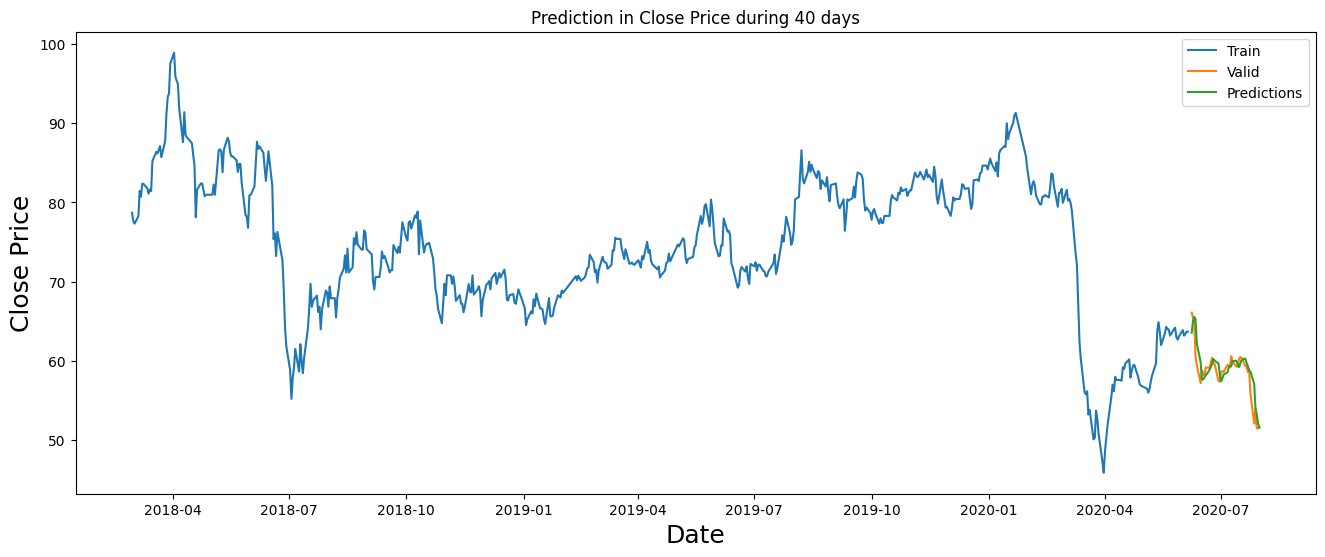

            Close  Predictions
Date                          
2020-06-08   66.1    63.557354
2020-06-09   65.5    65.034302
2020-06-10   65.0    65.555275
2020-06-11   60.5    65.256119
2020-06-12   59.5    62.223450
2020-06-15   57.2    59.848572
2020-06-16   58.8    57.659435
2020-06-17   58.3    57.667629
2020-06-18   58.2    57.943806
2020-06-19   59.2    58.172760
2020-06-22   59.1    58.867512
2020-06-23   59.8    59.236027
2020-06-24   60.4    59.712215
2020-06-25   59.6    60.253258
2020-06-26   59.6    60.014542
2020-06-29   57.5    59.705372
2020-06-30   57.4    58.338768
2020-07-01   58.6    57.438145
2020-07-02   58.7    57.779144
2020-07-03   58.6    58.290886
2020-07-06   59.5    58.547867
2020-07-07   59.4    59.125721
2020-07-08   59.2    59.393406
2020-07-09   60.6    59.322704
2020-07-10   59.9    59.987583
2020-07-13   59.3    60.024334
2020-07-14   59.3    59.560658
2020-07-15   60.2    59.229904
2020-07-16   60.5    59.607990
2020-07-17   60.4    60.108227
2020-07-

In [24]:
# plot the data after predicting
train = data[:train_size]
valid = data[train_size: train_size+N_forecast]
valid['Predictions'] = predictions

# Visualize the data
plt.figure(figsize=(16,6))
plt.title(f'Prediction in Close Price during {N_forecast} days')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Valid', 'Predictions'], loc='upper right')
plt.show()
print(valid)

- Biểu đồ bên dưới là kết quả của việc tính toán biến động giá cổ phiếu trong khoảng thời gian là <b>*N_forecast*</b>
- Thời gian ghi nhận giá cổ phiếu cuối cùng của tập huấn luyện được sử dụng xem như giá trị cổ phiếu hiện tại mà ta có. Dựa vào giá trị này, ta tính toán sự biến động của cổ phiếu trong khoảng thời gian <b>*N_forecast*</b>
- Ví dụ như <b>*N_forecast = 40*</b>, giá trị cổ phiếu hiện tại là 62.5 (ghi nhận tại 26-05-2020) thì kết quả ta thu được chính là biến động của giá cổ phiếu trong 40 ngày sau (21-07-2020).

2020-06-05


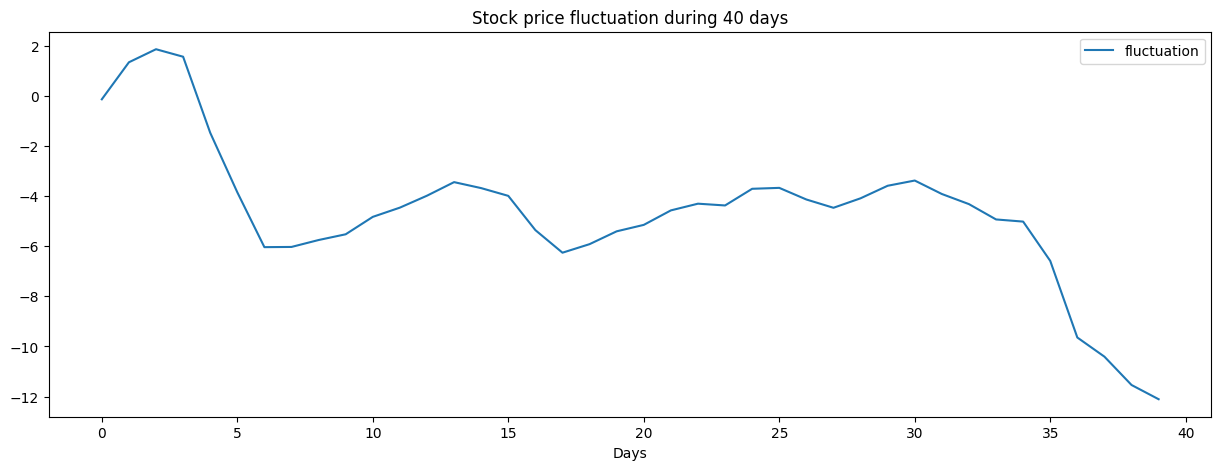

In [25]:
recent_date = train.index[-1]
recent_value = train.iloc[-1]['Close']
predictions = predictions.reshape(-1)
fluctuation = predictions - recent_value

df = {"Prediction": predictions, "Fluctuation": fluctuation}
result = pd.DataFrame(df)

plt.figure(figsize=(15,5))

result['Fluctuation'].plot(title=f'Stock price fluctuation during {N_forecast} days')
plt.xlabel('Days')
plt.legend(['fluctuation'], loc = 'upper right')
print(recent_date)

<h4><b>f. Nhận xét</b></h4>
- Với cách thực hiện trên (dùng toàn bộ dataset để huấn luyện và kiểm thử) kết quả cho ra rất tốt và gần như chênh lệch không đáng kể. <br>
- Ngược lại, với trường hợp thu thập dữ liệu thông qua việc dự đoán (tức là sử dụng dữ liệu có được trong hôm nay trở về trước để dự đoán dữ liệu của N ngày tiếp theo và thu thập kết quả dự đoán để làm tập dữ liệu cho mô hình dự doán tiếp tục), mô hình chỉ có thể đưa ra dự đoán đúng với trường hợp giá trị N nhỏ (khoảng 5 ngày). Do đó, cần lưu ý với kết quả dự đoán của trường hợp này. 